# 3 layer LSTM Encoder Decoder, dropout. 120 day input, 10 day forecast

In [1]:
import numpy as np
import pandas as pd
import json
import os
import math
import datetime as dt
import matplotlib.pyplot as plt
from numpy import newaxis
from keras.optimizers import Adam
from keras.layers import Conv1D, Dense, Activation, Dropout, LSTM, CuDNNLSTM, BatchNormalization, RepeatVector, TimeDistributed
from keras.models import Sequential, load_model
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras import regularizers

import utils
import model_funcs

%load_ext autoreload
%autoreload 2

plt.rcParams['figure.figsize'] = [16, 9]
%matplotlib inline

Using TensorFlow backend.


In [2]:
df = pd.read_csv('data_25_normalized.csv', index_col='Date')
num_skew_end = 15
data = df.values[:-num_skew_end]

In [6]:
df1 = pd.DataFrame(data)
df1.tail()
df.tail(20)

,Price,Open,High,Low,Volume,Change,Trend,Seasonal,Residual,rsi,...,MovingAverage30,MovingAverage50,MovingAverage100,MovingAverage200,VAR_Price,VAR_Open,VAR_High,VAR_Low,VAR_Change,Kalman
Date,,,,,,,,,,,,,,,,,,,,,
2019-03-26,0.170118,0.169800,0.164055,0.175467,0.001515,-0.192678,0.0,-0.473755,0.0,0.438354,...,0.202326,0.208465,0.238856,0.238856,-0.032041,0.961411,0.386322,0.579865,-0.201770,0.180461
2019-03-27,0.175446,0.170108,0.168918,0.177482,0.001771,-0.081906,0.0,-0.490788,0.0,0.642518,...,0.202793,0.209297,0.239310,0.239310,-0.030404,0.961398,0.411725,0.583005,-0.082995,0.184515
2019-03-28,0.174579,0.175436,0.168834,0.181491,0.001085,-0.218493,0.0,-0.519770,0.0,0.599615,...,0.203277,0.210198,0.239626,0.239626,-0.026811,0.961410,0.381605,0.581541,-0.218100,0.184824
2019-03-29,0.178706,0.174574,0.173108,0.182279,0.002304,-0.110537,0.0,-0.612241,0.0,0.706100,...,0.203923,0.211220,0.239992,0.239992,-0.032167,0.961436,0.411671,0.584387,-0.112128,0.188040
2019-03-30,0.179223,0.178776,0.173895,0.184194,0.001536,-0.188923,0.0,-0.660725,0.0,0.717186,...,0.204586,0.211873,0.240023,0.240023,-0.029850,0.961966,0.390956,0.579701,-0.188946,0.188909
2019-03-31,0.178711,0.179213,0.173045,0.185588,0.001413,-0.210514,0.0,-0.016582,0.0,0.687376,...,0.205216,0.212513,0.240245,0.240245,-0.031068,0.961397,0.385786,0.581393,-0.213578,0.189398
2019-04-01,0.181017,0.178701,0.174998,0.185288,0.002222,-0.150904,0.0,-0.012714,0.0,0.743143,...,0.205939,0.213189,0.240404,0.240404,-0.032877,0.961401,0.400407,0.579213,-0.152457,0.195154
2019-04-02,0.219498,0.181007,0.213881,0.188991,0.014047,0.609012,0.0,0.200558,0.0,0.954142,...,0.208298,0.214969,0.241211,0.241211,-0.015832,0.961404,0.577576,0.590451,0.622855,0.225531
2019-04-03,0.225392,0.219485,0.233772,0.226218,0.013084,-0.094109,0.0,0.607925,0.0,0.961902,...,0.211112,0.216908,0.242042,0.242042,0.020099,0.961423,0.444577,0.645167,-0.078549,0.233757


In [3]:
num_input = 120
num_out = 10
train_X, train_y, dev_X, dev_y, test_X, test_y, train_y_acc, dev_y_acc, test_y_acc = utils.prepare_data(data, num_input, num_preds=num_out)

train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
dev_y = dev_y.reshape((dev_y.shape[0], dev_y.shape[1], 1))
test_y = test_y.reshape((test_y.shape[0], test_y.shape[1], 1))
train_y_acc = train_y_acc.reshape((train_y.shape[0], train_y.shape[1], 1))
dev_y_acc = dev_y_acc.reshape((dev_y.shape[0], dev_y.shape[1], 1))
test_y_acc = test_y_acc.reshape((test_y.shape[0], test_y.shape[1], 1))

print("train_X shape", train_X.shape)
print("train_y shape", train_y.shape)
print("dev_X shape", dev_X.shape)
print("dev_y shape", dev_y.shape)
print("test_X shape", test_X.shape)
print("test_y shape", test_y.shape)
print("train_y_acc shape", train_y_acc.shape)
print("dev_y_acc shape", dev_y_acc.shape)
print("test_y_acc shape", test_y_acc.shape)

var_preds_dev = utils.var_predict(dev_X[:, :, 0:5], num_out)
arima_preds_dev = utils.arima_predict(dev_X[:, :, 0], num_out)

var_preds_test = utils.var_predict(test_X[:, :, 0:5], num_out)
arima_preds_test = utils.arima_predict(test_X[:, :, 0], num_out)


train_X shape (585, 120, 25)
train_y shape (585, 10, 1)
dev_X shape (69, 120, 25)
dev_y shape (69, 10, 1)
test_X shape (35, 120, 25)
test_y shape (35, 10, 1)
train_y_acc shape (585, 10, 1)
dev_y_acc shape (69, 10, 1)
test_y_acc shape (35, 10, 1)


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [4]:
i = 13
save_dir = f'results/{i}/'
if not os.path.exists(save_dir): os.makedirs(save_dir)
hyperparams = utils.generate_hyperparams(1)
hps = pd.DataFrame(hyperparams)
hps.to_csv(save_dir+'hyperparams.csv')
print(hps)
results = []

   batch_size         decay   dropout        lr  num_units  wlen
0          32  2.153232e-07 -0.130953  0.000003        200   110


   batch_size         decay   dropout        lr  num_units  wlen
0          32  3.911302e-07 -0.101797  0.000054         50   100
Instructions for updating:
Colocations handled automatically by placer.
[Model] Training Started
[Model] 1000 epochs, 32 batch size
Instructions for updating:
Use tf.cast instead.
Train on 602 samples, validate on 71 samples
Epoch 1/1000
602/602 [==============================] - 2s 3ms/step - loss: 0.0715 - val_loss: 0.0429
Epoch 2/1000
602/602 [==============================] - 0s 815us/step - loss: 0.0347 - val_loss: 0.0288
Epoch 3/1000
602/602 [==============================] - 0s 815us/step - loss: 0.0263 - val_loss: 0.0238
Epoch 4/1000
602/602 [==============================] - 0s 821us/step - loss: 0.0220 - val_loss: 0.0200
Epoch 5/1000
602/602 [==============================] - 0s 819us/step - loss: 0.0190 - val_loss: 0.0176
Epoch 6/1000
602/602 [==============================] - 0s 813us/step - loss: 0.0169 - val_loss: 0.0155
Epoch 7/1000
602/602 [=

602/602 [==============================] - 0s 815us/step - loss: 0.0011 - val_loss: 0.0010
Epoch 72/1000
602/602 [==============================] - 0s 815us/step - loss: 0.0011 - val_loss: 9.9351e-04
Epoch 73/1000
602/602 [==============================] - 0s 816us/step - loss: 0.0010 - val_loss: 9.7461e-04
Epoch 74/1000
602/602 [==============================] - 0s 818us/step - loss: 0.0010 - val_loss: 9.9207e-04
Epoch 75/1000
602/602 [==============================] - 0s 816us/step - loss: 0.0010 - val_loss: 0.0010
Epoch 76/1000
602/602 [==============================] - 0s 806us/step - loss: 0.0010 - val_loss: 9.5754e-04
Epoch 77/1000
602/602 [==============================] - 0s 821us/step - loss: 9.9422e-04 - val_loss: 9.7895e-04
Epoch 78/1000
602/602 [==============================] - 0s 815us/step - loss: 9.7903e-04 - val_loss: 9.4828e-04
Epoch 79/1000
602/602 [==============================] - 0s 812us/step - loss: 9.7866e-04 - val_loss: 9.3979e-04
Epoch 80/1000
602/602 [======

Epoch 215/1000
602/602 [==============================] - 0s 815us/step - loss: 5.3082e-04 - val_loss: 5.8944e-04
Epoch 216/1000
602/602 [==============================] - 0s 815us/step - loss: 5.1659e-04 - val_loss: 5.2589e-04
Epoch 217/1000
602/602 [==============================] - 0s 812us/step - loss: 5.0964e-04 - val_loss: 5.5305e-04
Epoch 218/1000
602/602 [==============================] - 0s 816us/step - loss: 4.9798e-04 - val_loss: 5.2767e-04
Epoch 219/1000
602/602 [==============================] - 0s 819us/step - loss: 4.9037e-04 - val_loss: 5.3317e-04
Epoch 220/1000
602/602 [==============================] - 0s 821us/step - loss: 4.8538e-04 - val_loss: 5.2164e-04
Epoch 221/1000
602/602 [==============================] - 0s 817us/step - loss: 4.8781e-04 - val_loss: 5.3273e-04
Epoch 222/1000
602/602 [==============================] - 0s 819us/step - loss: 5.0054e-04 - val_loss: 5.2122e-04
Epoch 223/1000
602/602 [==============================] - 0s 810us/step - loss: 4.9286e-

Epoch 287/1000
602/602 [==============================] - 0s 815us/step - loss: 4.0383e-04 - val_loss: 4.6261e-04
Epoch 288/1000
602/602 [==============================] - 0s 815us/step - loss: 4.0587e-04 - val_loss: 4.5021e-04
Epoch 289/1000
602/602 [==============================] - 0s 821us/step - loss: 4.1186e-04 - val_loss: 4.8516e-04
Epoch 290/1000
602/602 [==============================] - 0s 812us/step - loss: 4.0632e-04 - val_loss: 4.5325e-04
Epoch 291/1000
602/602 [==============================] - 0s 814us/step - loss: 3.9862e-04 - val_loss: 4.4399e-04
Epoch 292/1000
602/602 [==============================] - 0s 819us/step - loss: 4.0160e-04 - val_loss: 4.5336e-04
Epoch 293/1000
602/602 [==============================] - 0s 815us/step - loss: 4.0430e-04 - val_loss: 4.6104e-04
Epoch 294/1000
602/602 [==============================] - 0s 817us/step - loss: 3.9786e-04 - val_loss: 4.3798e-04
Epoch 295/1000
602/602 [==============================] - 0s 821us/step - loss: 4.0318e-

Epoch 359/1000
602/602 [==============================] - 0s 816us/step - loss: 3.6803e-04 - val_loss: 4.0331e-04
Epoch 360/1000
602/602 [==============================] - 0s 817us/step - loss: 3.4278e-04 - val_loss: 4.1137e-04
Epoch 361/1000
602/602 [==============================] - 0s 816us/step - loss: 3.4165e-04 - val_loss: 3.9912e-04
Epoch 362/1000
602/602 [==============================] - 0s 816us/step - loss: 3.3647e-04 - val_loss: 3.9674e-04
Epoch 363/1000
602/602 [==============================] - 0s 820us/step - loss: 3.4222e-04 - val_loss: 4.0142e-04
Epoch 364/1000
602/602 [==============================] - 0s 806us/step - loss: 3.5195e-04 - val_loss: 4.2827e-04
Epoch 365/1000
602/602 [==============================] - 0s 822us/step - loss: 3.4642e-04 - val_loss: 4.1336e-04
Epoch 366/1000
602/602 [==============================] - 0s 816us/step - loss: 3.4840e-04 - val_loss: 4.0897e-04
Epoch 367/1000
602/602 [==============================] - 0s 817us/step - loss: 3.4753e-

Epoch 431/1000
602/602 [==============================] - 0s 814us/step - loss: 3.1303e-04 - val_loss: 3.8694e-04
Epoch 432/1000
602/602 [==============================] - 0s 816us/step - loss: 3.0994e-04 - val_loss: 3.7805e-04
Epoch 433/1000
602/602 [==============================] - 0s 820us/step - loss: 3.0627e-04 - val_loss: 3.7781e-04
Epoch 434/1000
602/602 [==============================] - 0s 810us/step - loss: 3.0960e-04 - val_loss: 3.6750e-04
Epoch 435/1000
602/602 [==============================] - 0s 817us/step - loss: 3.0076e-04 - val_loss: 3.7480e-04
Epoch 436/1000
602/602 [==============================] - 0s 819us/step - loss: 3.1303e-04 - val_loss: 3.7354e-04
Epoch 437/1000
602/602 [==============================] - 0s 813us/step - loss: 3.1442e-04 - val_loss: 3.7664e-04
Epoch 438/1000
602/602 [==============================] - 0s 823us/step - loss: 3.2766e-04 - val_loss: 3.8480e-04
Epoch 439/1000
602/602 [==============================] - 0s 811us/step - loss: 3.0755e-

Epoch 503/1000
602/602 [==============================] - 0s 805us/step - loss: 2.7644e-04 - val_loss: 3.4912e-04
Epoch 504/1000
602/602 [==============================] - 0s 814us/step - loss: 2.8259e-04 - val_loss: 3.4764e-04
Epoch 505/1000
602/602 [==============================] - 0s 815us/step - loss: 2.7927e-04 - val_loss: 3.6338e-04
Epoch 506/1000
602/602 [==============================] - 0s 815us/step - loss: 2.8155e-04 - val_loss: 3.5712e-04
Epoch 507/1000
602/602 [==============================] - 0s 813us/step - loss: 2.8235e-04 - val_loss: 3.4934e-04
Epoch 508/1000
602/602 [==============================] - 0s 816us/step - loss: 2.7821e-04 - val_loss: 3.5283e-04
Epoch 509/1000
602/602 [==============================] - 0s 826us/step - loss: 2.8262e-04 - val_loss: 3.7218e-04
Epoch 510/1000
602/602 [==============================] - 0s 809us/step - loss: 2.7821e-04 - val_loss: 3.4968e-04
Epoch 511/1000
602/602 [==============================] - 0s 813us/step - loss: 2.7584e-

Epoch 575/1000
602/602 [==============================] - 0s 818us/step - loss: 2.6313e-04 - val_loss: 3.3293e-04
Epoch 576/1000
602/602 [==============================] - 0s 809us/step - loss: 2.5850e-04 - val_loss: 3.4519e-04
Epoch 577/1000
602/602 [==============================] - 0s 815us/step - loss: 2.7051e-04 - val_loss: 3.4330e-04
Epoch 578/1000
602/602 [==============================] - 0s 816us/step - loss: 2.6582e-04 - val_loss: 3.3532e-04
Epoch 579/1000
602/602 [==============================] - 0s 815us/step - loss: 2.6450e-04 - val_loss: 3.5832e-04
Epoch 580/1000
602/602 [==============================] - 0s 823us/step - loss: 2.6752e-04 - val_loss: 3.4208e-04
Epoch 581/1000
602/602 [==============================] - 0s 813us/step - loss: 2.5940e-04 - val_loss: 3.4194e-04
Epoch 582/1000
602/602 [==============================] - 0s 812us/step - loss: 2.5559e-04 - val_loss: 3.2866e-04
Epoch 583/1000
602/602 [==============================] - 0s 814us/step - loss: 2.5555e-

Epoch 647/1000
602/602 [==============================] - 0s 812us/step - loss: 2.4636e-04 - val_loss: 3.3523e-04
Epoch 648/1000
602/602 [==============================] - 0s 807us/step - loss: 2.4801e-04 - val_loss: 3.2978e-04
Epoch 649/1000
602/602 [==============================] - 0s 812us/step - loss: 2.4300e-04 - val_loss: 3.2464e-04
Epoch 650/1000
602/602 [==============================] - 0s 814us/step - loss: 2.4326e-04 - val_loss: 3.3157e-04
Epoch 651/1000
602/602 [==============================] - 0s 810us/step - loss: 2.4183e-04 - val_loss: 3.3190e-04
Epoch 652/1000
602/602 [==============================] - 0s 815us/step - loss: 2.3795e-04 - val_loss: 3.2568e-04
Epoch 653/1000
602/602 [==============================] - 0s 816us/step - loss: 2.4001e-04 - val_loss: 3.2293e-04
Epoch 654/1000
602/602 [==============================] - 0s 814us/step - loss: 2.4220e-04 - val_loss: 3.2477e-04
Epoch 655/1000
602/602 [==============================] - 0s 808us/step - loss: 2.5114e-

Epoch 719/1000
602/602 [==============================] - 0s 818us/step - loss: 2.3305e-04 - val_loss: 3.2389e-04
Epoch 720/1000
602/602 [==============================] - 0s 816us/step - loss: 2.3504e-04 - val_loss: 3.2387e-04
Epoch 721/1000
602/602 [==============================] - 0s 816us/step - loss: 2.3311e-04 - val_loss: 3.3268e-04
Epoch 722/1000
602/602 [==============================] - 0s 812us/step - loss: 2.3129e-04 - val_loss: 3.2359e-04
Epoch 723/1000
602/602 [==============================] - 0s 815us/step - loss: 2.3421e-04 - val_loss: 3.3621e-04
Epoch 724/1000
602/602 [==============================] - 0s 811us/step - loss: 2.3335e-04 - val_loss: 3.4228e-04
Epoch 725/1000
602/602 [==============================] - 0s 804us/step - loss: 2.5632e-04 - val_loss: 3.3185e-04
Epoch 726/1000
602/602 [==============================] - 0s 813us/step - loss: 2.5095e-04 - val_loss: 3.3110e-04
Epoch 727/1000
602/602 [==============================] - 0s 820us/step - loss: 2.4735e-

Epoch 791/1000
602/602 [==============================] - 0s 817us/step - loss: 2.2198e-04 - val_loss: 3.2879e-04
Epoch 792/1000
602/602 [==============================] - 0s 815us/step - loss: 2.2472e-04 - val_loss: 3.2347e-04
Epoch 793/1000
602/602 [==============================] - 0s 819us/step - loss: 2.3322e-04 - val_loss: 3.1692e-04
Epoch 794/1000
602/602 [==============================] - 0s 814us/step - loss: 2.2444e-04 - val_loss: 3.0884e-04
Epoch 795/1000
602/602 [==============================] - 0s 818us/step - loss: 2.1647e-04 - val_loss: 3.0727e-04
Epoch 796/1000
602/602 [==============================] - 0s 813us/step - loss: 2.1875e-04 - val_loss: 3.2449e-04
Epoch 797/1000
602/602 [==============================] - 0s 809us/step - loss: 2.2355e-04 - val_loss: 3.0969e-04
Epoch 798/1000
602/602 [==============================] - 0s 816us/step - loss: 2.1646e-04 - val_loss: 3.1343e-04
Epoch 799/1000
602/602 [==============================] - 0s 815us/step - loss: 2.1770e-

Epoch 863/1000
602/602 [==============================] - 0s 813us/step - loss: 2.1202e-04 - val_loss: 3.1226e-04
Epoch 864/1000
602/602 [==============================] - 0s 817us/step - loss: 2.1416e-04 - val_loss: 3.0984e-04
Epoch 865/1000
602/602 [==============================] - 0s 816us/step - loss: 2.1612e-04 - val_loss: 3.0864e-04
Epoch 866/1000
602/602 [==============================] - 0s 813us/step - loss: 2.1055e-04 - val_loss: 3.0701e-04
Epoch 867/1000
602/602 [==============================] - 0s 815us/step - loss: 2.1279e-04 - val_loss: 3.0062e-04
Epoch 868/1000
602/602 [==============================] - 0s 814us/step - loss: 2.0703e-04 - val_loss: 3.0313e-04
Epoch 869/1000
602/602 [==============================] - 0s 822us/step - loss: 2.1013e-04 - val_loss: 3.1225e-04
Epoch 870/1000
602/602 [==============================] - 0s 815us/step - loss: 2.1012e-04 - val_loss: 2.9718e-04
Epoch 871/1000
602/602 [==============================] - 0s 821us/step - loss: 2.1344e-

Epoch 935/1000
602/602 [==============================] - 0s 808us/step - loss: 2.0451e-04 - val_loss: 3.1939e-04
Epoch 936/1000
602/602 [==============================] - 0s 824us/step - loss: 2.0988e-04 - val_loss: 2.9343e-04
Epoch 937/1000
602/602 [==============================] - 0s 821us/step - loss: 2.0166e-04 - val_loss: 2.9929e-04
Epoch 938/1000
602/602 [==============================] - 0s 816us/step - loss: 1.9948e-04 - val_loss: 3.0023e-04
Epoch 939/1000
602/602 [==============================] - 0s 819us/step - loss: 1.9791e-04 - val_loss: 3.0049e-04
Epoch 940/1000
602/602 [==============================] - 0s 809us/step - loss: 2.0097e-04 - val_loss: 2.9423e-04
Epoch 941/1000
602/602 [==============================] - 0s 812us/step - loss: 2.0036e-04 - val_loss: 2.9098e-04
Epoch 942/1000
602/602 [==============================] - 0s 811us/step - loss: 2.0058e-04 - val_loss: 3.0584e-04
Epoch 943/1000
602/602 [==============================] - 0s 807us/step - loss: 2.0287e-

585/585 [==============================] - 0s 698us/step - loss: 3.3694e-04 - val_loss: 5.2468e-04
Epoch 79/1000
585/585 [==============================] - 0s 699us/step - loss: 3.5908e-04 - val_loss: 5.0648e-04
Epoch 80/1000
585/585 [==============================] - 0s 696us/step - loss: 3.6253e-04 - val_loss: 4.8409e-04
Epoch 81/1000
585/585 [==============================] - 0s 699us/step - loss: 3.3226e-04 - val_loss: 4.7632e-04
Epoch 82/1000
585/585 [==============================] - 0s 706us/step - loss: 3.2487e-04 - val_loss: 4.8623e-04
Epoch 83/1000
585/585 [==============================] - 0s 706us/step - loss: 3.3731e-04 - val_loss: 4.6891e-04
Epoch 84/1000
585/585 [==============================] - 0s 705us/step - loss: 3.1816e-04 - val_loss: 4.8688e-04
Epoch 85/1000
585/585 [==============================] - 0s 699us/step - loss: 3.4290e-04 - val_loss: 5.6017e-04
Epoch 86/1000
585/585 [==============================] - 0s 699us/step - loss: 3.2420e-04 - val_loss: 5.0985e-

585/585 [==============================] - 0s 705us/step - loss: 4.7967e-04 - val_loss: 4.3730e-04
Epoch 223/1000
585/585 [==============================] - 0s 702us/step - loss: 3.5280e-04 - val_loss: 6.0309e-04
Epoch 224/1000
585/585 [==============================] - 0s 702us/step - loss: 3.3868e-04 - val_loss: 5.1104e-04
Epoch 225/1000
585/585 [==============================] - 0s 696us/step - loss: 2.8780e-04 - val_loss: 4.0486e-04
Epoch 226/1000
585/585 [==============================] - 0s 696us/step - loss: 2.3936e-04 - val_loss: 3.8203e-04
Epoch 227/1000
585/585 [==============================] - 0s 696us/step - loss: 2.2935e-04 - val_loss: 3.7215e-04
Epoch 228/1000
585/585 [==============================] - 0s 696us/step - loss: 2.1340e-04 - val_loss: 6.5214e-04
Epoch 229/1000
585/585 [==============================] - 0s 698us/step - loss: 4.1054e-04 - val_loss: 5.3590e-04
Epoch 230/1000
585/585 [==============================] - 0s 700us/step - loss: 3.3699e-04 - val_loss: 

Epoch 294/1000
585/585 [==============================] - 0s 706us/step - loss: 1.6529e-04 - val_loss: 2.7481e-04
Epoch 295/1000
585/585 [==============================] - 0s 704us/step - loss: 1.6764e-04 - val_loss: 3.4401e-04
Epoch 296/1000
585/585 [==============================] - 0s 704us/step - loss: 2.5020e-04 - val_loss: 4.3711e-04
Epoch 297/1000
585/585 [==============================] - 0s 700us/step - loss: 4.3798e-04 - val_loss: 9.9023e-04
Epoch 298/1000
585/585 [==============================] - 0s 705us/step - loss: 4.4790e-04 - val_loss: 5.1670e-04
Epoch 299/1000
585/585 [==============================] - 0s 705us/step - loss: 3.0294e-04 - val_loss: 4.4726e-04
Epoch 300/1000
585/585 [==============================] - 0s 704us/step - loss: 2.8802e-04 - val_loss: 4.0863e-04
Epoch 301/1000
585/585 [==============================] - 0s 706us/step - loss: 3.7842e-04 - val_loss: 4.4728e-04
Epoch 302/1000
585/585 [==============================] - 0s 704us/step - loss: 2.9607e-

Epoch 366/1000
585/585 [==============================] - 0s 707us/step - loss: 1.4144e-04 - val_loss: 2.4853e-04
Epoch 367/1000
585/585 [==============================] - 0s 708us/step - loss: 1.6868e-04 - val_loss: 2.7546e-04
Epoch 368/1000
585/585 [==============================] - 0s 706us/step - loss: 1.6273e-04 - val_loss: 2.6494e-04
Epoch 369/1000
585/585 [==============================] - 0s 706us/step - loss: 1.4918e-04 - val_loss: 2.4497e-04
Epoch 370/1000
585/585 [==============================] - 0s 711us/step - loss: 1.6258e-04 - val_loss: 2.6682e-04
Epoch 371/1000
585/585 [==============================] - 0s 706us/step - loss: 1.4398e-04 - val_loss: 2.6219e-04
Epoch 372/1000
585/585 [==============================] - 0s 707us/step - loss: 1.6822e-04 - val_loss: 3.9362e-04
Epoch 373/1000
585/585 [==============================] - 0s 708us/step - loss: 1.8141e-04 - val_loss: 2.3627e-04
Epoch 374/1000
585/585 [==============================] - 0s 706us/step - loss: 1.4830e-

Epoch 438/1000
585/585 [==============================] - 0s 703us/step - loss: 1.7872e-04 - val_loss: 3.0129e-04
Epoch 439/1000
585/585 [==============================] - 0s 705us/step - loss: 1.6130e-04 - val_loss: 2.4445e-04
Epoch 440/1000
585/585 [==============================] - 0s 699us/step - loss: 1.3423e-04 - val_loss: 2.3509e-04
Epoch 441/1000
585/585 [==============================] - 0s 700us/step - loss: 1.1345e-04 - val_loss: 2.0628e-04
Epoch 442/1000
585/585 [==============================] - 0s 698us/step - loss: 1.1693e-04 - val_loss: 1.9088e-04
Epoch 443/1000
585/585 [==============================] - 0s 697us/step - loss: 1.0612e-04 - val_loss: 2.0183e-04
Epoch 444/1000
585/585 [==============================] - 0s 698us/step - loss: 9.9234e-05 - val_loss: 2.0457e-04
Epoch 445/1000
585/585 [==============================] - 0s 704us/step - loss: 1.0133e-04 - val_loss: 2.3807e-04
Epoch 446/1000
585/585 [==============================] - 0s 699us/step - loss: 1.2153e-

Epoch 510/1000
585/585 [==============================] - 0s 704us/step - loss: 1.3420e-04 - val_loss: 2.4049e-04
Epoch 511/1000
585/585 [==============================] - 0s 707us/step - loss: 1.2199e-04 - val_loss: 2.2055e-04
Epoch 512/1000
585/585 [==============================] - 0s 698us/step - loss: 1.1914e-04 - val_loss: 2.0541e-04
Epoch 513/1000
585/585 [==============================] - 0s 706us/step - loss: 1.0286e-04 - val_loss: 1.8302e-04
Epoch 514/1000
585/585 [==============================] - 0s 714us/step - loss: 9.8557e-05 - val_loss: 1.9323e-04
Epoch 515/1000
585/585 [==============================] - 0s 709us/step - loss: 1.1972e-04 - val_loss: 2.5710e-04
Epoch 516/1000
585/585 [==============================] - 0s 709us/step - loss: 1.2508e-04 - val_loss: 2.0053e-04
Epoch 517/1000
585/585 [==============================] - 0s 711us/step - loss: 1.1538e-04 - val_loss: 2.3971e-04
Epoch 518/1000
585/585 [==============================] - 0s 712us/step - loss: 1.0626e-

Epoch 582/1000
585/585 [==============================] - 0s 707us/step - loss: 8.7615e-05 - val_loss: 2.0558e-04
Epoch 583/1000
585/585 [==============================] - 0s 702us/step - loss: 8.6391e-05 - val_loss: 2.4174e-04
Epoch 584/1000
585/585 [==============================] - 0s 701us/step - loss: 8.4562e-05 - val_loss: 2.3649e-04
Epoch 585/1000
585/585 [==============================] - 0s 699us/step - loss: 8.7311e-05 - val_loss: 1.9384e-04
Epoch 586/1000
585/585 [==============================] - 0s 704us/step - loss: 7.8086e-05 - val_loss: 2.1155e-04
Epoch 587/1000
585/585 [==============================] - 0s 697us/step - loss: 7.8917e-05 - val_loss: 1.8935e-04
Epoch 588/1000
585/585 [==============================] - 0s 698us/step - loss: 7.1974e-05 - val_loss: 1.8043e-04
Epoch 589/1000
585/585 [==============================] - 0s 703us/step - loss: 7.3271e-05 - val_loss: 1.7890e-04
Epoch 590/1000
585/585 [==============================] - 0s 702us/step - loss: 7.5994e-

Epoch 654/1000
585/585 [==============================] - 0s 695us/step - loss: 1.2317e-04 - val_loss: 2.4789e-04
Epoch 655/1000
585/585 [==============================] - 0s 701us/step - loss: 1.1470e-04 - val_loss: 2.2021e-04
Epoch 656/1000
585/585 [==============================] - 0s 700us/step - loss: 1.1262e-04 - val_loss: 2.4724e-04
Epoch 657/1000
585/585 [==============================] - 0s 704us/step - loss: 9.8709e-05 - val_loss: 2.6269e-04
Epoch 658/1000
585/585 [==============================] - 0s 700us/step - loss: 9.3617e-05 - val_loss: 1.7900e-04
Epoch 659/1000
585/585 [==============================] - 0s 701us/step - loss: 8.4861e-05 - val_loss: 1.8851e-04
Epoch 660/1000
585/585 [==============================] - 0s 704us/step - loss: 7.5357e-05 - val_loss: 2.0639e-04
Epoch 661/1000
585/585 [==============================] - 0s 702us/step - loss: 8.4434e-05 - val_loss: 2.0152e-04
Epoch 662/1000
585/585 [==============================] - 0s 702us/step - loss: 8.0792e-

Epoch 726/1000
585/585 [==============================] - 0s 708us/step - loss: 5.5859e-05 - val_loss: 1.7046e-04
Epoch 727/1000
585/585 [==============================] - 0s 705us/step - loss: 6.1964e-05 - val_loss: 1.9521e-04
Epoch 728/1000
585/585 [==============================] - 0s 701us/step - loss: 6.3528e-05 - val_loss: 2.0326e-04
Epoch 729/1000
585/585 [==============================] - 0s 704us/step - loss: 9.0017e-05 - val_loss: 2.8290e-04
Epoch 730/1000
585/585 [==============================] - 0s 707us/step - loss: 1.5850e-04 - val_loss: 1.9118e-04
Epoch 731/1000
585/585 [==============================] - 0s 707us/step - loss: 1.1545e-04 - val_loss: 2.6343e-04
Epoch 732/1000
585/585 [==============================] - 0s 703us/step - loss: 1.2241e-04 - val_loss: 2.1285e-04
Epoch 733/1000
585/585 [==============================] - 0s 705us/step - loss: 1.6673e-04 - val_loss: 2.6105e-04
Epoch 734/1000
585/585 [==============================] - 0s 704us/step - loss: 1.8600e-

Epoch 798/1000
585/585 [==============================] - 0s 706us/step - loss: 5.4209e-05 - val_loss: 1.6831e-04
Epoch 799/1000
585/585 [==============================] - 0s 709us/step - loss: 5.3269e-05 - val_loss: 1.6430e-04
Epoch 800/1000
585/585 [==============================] - 0s 703us/step - loss: 5.0213e-05 - val_loss: 1.6392e-04
Epoch 801/1000
585/585 [==============================] - 0s 706us/step - loss: 5.1480e-05 - val_loss: 1.6671e-04
Epoch 802/1000
585/585 [==============================] - 0s 704us/step - loss: 4.8720e-05 - val_loss: 1.5221e-04
Epoch 803/1000
585/585 [==============================] - 0s 699us/step - loss: 4.5073e-05 - val_loss: 1.6217e-04
Epoch 804/1000
585/585 [==============================] - 0s 702us/step - loss: 4.1727e-05 - val_loss: 1.5336e-04
Epoch 805/1000
585/585 [==============================] - 0s 704us/step - loss: 4.1874e-05 - val_loss: 1.5993e-04
Epoch 806/1000
585/585 [==============================] - 0s 700us/step - loss: 4.1627e-

594/594 [==============================] - 1s 2ms/step - loss: 0.0013 - val_loss: 0.0016
Epoch 128/1000
594/594 [==============================] - 1s 2ms/step - loss: 0.0013 - val_loss: 0.0016
Epoch 129/1000
594/594 [==============================] - 1s 2ms/step - loss: 0.0012 - val_loss: 0.0016
Epoch 130/1000
594/594 [==============================] - 1s 2ms/step - loss: 0.0012 - val_loss: 0.0016
Epoch 131/1000
594/594 [==============================] - 1s 2ms/step - loss: 0.0012 - val_loss: 0.0016
Epoch 132/1000
594/594 [==============================] - 1s 2ms/step - loss: 0.0012 - val_loss: 0.0016
Epoch 133/1000
594/594 [==============================] - 1s 2ms/step - loss: 0.0012 - val_loss: 0.0015
Epoch 134/1000
594/594 [==============================] - 1s 2ms/step - loss: 0.0012 - val_loss: 0.0016
Epoch 135/1000
594/594 [==============================] - 1s 2ms/step - loss: 0.0012 - val_loss: 0.0015
Epoch 136/1000
594/594 [==============================] - 1s 2ms/step - loss: 0

594/594 [==============================] - 1s 2ms/step - loss: 6.4850e-04 - val_loss: 8.7702e-04
Epoch 279/1000
594/594 [==============================] - 1s 2ms/step - loss: 6.4083e-04 - val_loss: 8.7581e-04
Epoch 280/1000
594/594 [==============================] - 1s 2ms/step - loss: 6.3041e-04 - val_loss: 8.8680e-04
Epoch 281/1000
594/594 [==============================] - 1s 2ms/step - loss: 6.5034e-04 - val_loss: 8.8774e-04
Epoch 282/1000
594/594 [==============================] - 1s 2ms/step - loss: 6.4170e-04 - val_loss: 8.7251e-04
Epoch 283/1000
594/594 [==============================] - 1s 2ms/step - loss: 6.3255e-04 - val_loss: 8.5465e-04
Epoch 284/1000
594/594 [==============================] - 1s 2ms/step - loss: 6.1846e-04 - val_loss: 8.5715e-04
Epoch 285/1000
594/594 [==============================] - 1s 2ms/step - loss: 6.2184e-04 - val_loss: 8.8138e-04
Epoch 286/1000
594/594 [==============================] - 1s 2ms/step - loss: 6.1611e-04 - val_loss: 8.5139e-04
Epoch 2

594/594 [==============================] - 1s 2ms/step - loss: 4.6418e-04 - val_loss: 6.2560e-04
Epoch 425/1000
594/594 [==============================] - 1s 2ms/step - loss: 4.6057e-04 - val_loss: 6.2828e-04
Epoch 426/1000
594/594 [==============================] - 1s 2ms/step - loss: 4.6295e-04 - val_loss: 6.2293e-04
Epoch 427/1000
594/594 [==============================] - 1s 2ms/step - loss: 4.5547e-04 - val_loss: 6.2524e-04
Epoch 428/1000
594/594 [==============================] - 1s 2ms/step - loss: 4.6936e-04 - val_loss: 6.2387e-04
Epoch 429/1000
594/594 [==============================] - 1s 2ms/step - loss: 4.5612e-04 - val_loss: 6.2508e-04
Epoch 430/1000
594/594 [==============================] - 1s 2ms/step - loss: 4.5405e-04 - val_loss: 6.1825e-04
Epoch 431/1000
594/594 [==============================] - 1s 2ms/step - loss: 4.5780e-04 - val_loss: 6.2785e-04
Epoch 432/1000
594/594 [==============================] - 1s 2ms/step - loss: 4.5270e-04 - val_loss: 6.2217e-04
Epoch 4

594/594 [==============================] - 1s 2ms/step - loss: 3.8533e-04 - val_loss: 5.2924e-04
Epoch 571/1000
594/594 [==============================] - 1s 2ms/step - loss: 3.8564e-04 - val_loss: 5.2917e-04
Epoch 572/1000
594/594 [==============================] - 1s 2ms/step - loss: 3.9862e-04 - val_loss: 5.4319e-04
Epoch 573/1000
594/594 [==============================] - 1s 2ms/step - loss: 3.9378e-04 - val_loss: 5.2553e-04
Epoch 574/1000
594/594 [==============================] - 1s 2ms/step - loss: 3.9988e-04 - val_loss: 5.2733e-04
Epoch 575/1000
594/594 [==============================] - 1s 2ms/step - loss: 3.9056e-04 - val_loss: 5.2534e-04
Epoch 576/1000
594/594 [==============================] - 1s 2ms/step - loss: 3.8362e-04 - val_loss: 5.2173e-04
Epoch 577/1000
594/594 [==============================] - 1s 2ms/step - loss: 3.8232e-04 - val_loss: 5.1775e-04
Epoch 578/1000
594/594 [==============================] - 1s 2ms/step - loss: 3.8568e-04 - val_loss: 5.2971e-04
Epoch 5

594/594 [==============================] - 1s 2ms/step - loss: 3.4943e-04 - val_loss: 4.8924e-04
Epoch 717/1000
594/594 [==============================] - 1s 2ms/step - loss: 3.4651e-04 - val_loss: 4.8090e-04
Epoch 718/1000
594/594 [==============================] - 1s 2ms/step - loss: 3.4571e-04 - val_loss: 4.8083e-04
Epoch 719/1000
594/594 [==============================] - 1s 2ms/step - loss: 3.4581e-04 - val_loss: 4.9302e-04
Epoch 720/1000
594/594 [==============================] - 1s 2ms/step - loss: 3.4742e-04 - val_loss: 4.8258e-04
Epoch 721/1000
594/594 [==============================] - 1s 2ms/step - loss: 3.4565e-04 - val_loss: 4.7766e-04
Epoch 722/1000
594/594 [==============================] - 1s 2ms/step - loss: 3.4847e-04 - val_loss: 4.8471e-04
Epoch 723/1000
594/594 [==============================] - 1s 2ms/step - loss: 3.4991e-04 - val_loss: 4.8304e-04
Epoch 724/1000
594/594 [==============================] - 1s 2ms/step - loss: 3.5079e-04 - val_loss: 4.7614e-04
Epoch 7

594/594 [==============================] - 1s 2ms/step - loss: 3.1528e-04 - val_loss: 4.6233e-04
Epoch 863/1000
594/594 [==============================] - 1s 2ms/step - loss: 3.1690e-04 - val_loss: 4.7864e-04
Epoch 864/1000
594/594 [==============================] - 1s 2ms/step - loss: 3.2042e-04 - val_loss: 4.6916e-04
Epoch 865/1000
594/594 [==============================] - 1s 2ms/step - loss: 3.1717e-04 - val_loss: 4.6914e-04
Epoch 866/1000
594/594 [==============================] - 1s 2ms/step - loss: 3.1682e-04 - val_loss: 4.5605e-04
Epoch 867/1000
594/594 [==============================] - 1s 2ms/step - loss: 3.2414e-04 - val_loss: 4.5931e-04
Epoch 868/1000
594/594 [==============================] - 1s 2ms/step - loss: 3.2011e-04 - val_loss: 4.5652e-04
Epoch 869/1000
594/594 [==============================] - 1s 2ms/step - loss: 3.1597e-04 - val_loss: 4.7668e-04
Epoch 870/1000
594/594 [==============================] - 1s 2ms/step - loss: 3.1678e-04 - val_loss: 4.4754e-04
Epoch 8

611/611 [==============================] - 0s 237us/step - loss: 0.0168 - val_loss: 0.0122
Epoch 5/1000
611/611 [==============================] - 0s 236us/step - loss: 0.0141 - val_loss: 0.0109
Epoch 6/1000
611/611 [==============================] - 0s 235us/step - loss: 0.0117 - val_loss: 0.0087
Epoch 7/1000
611/611 [==============================] - 0s 236us/step - loss: 0.0098 - val_loss: 0.0074
Epoch 8/1000
611/611 [==============================] - 0s 233us/step - loss: 0.0081 - val_loss: 0.0059
Epoch 9/1000
611/611 [==============================] - 0s 234us/step - loss: 0.0069 - val_loss: 0.0053
Epoch 10/1000
611/611 [==============================] - 0s 234us/step - loss: 0.0063 - val_loss: 0.0050
Epoch 11/1000
611/611 [==============================] - 0s 233us/step - loss: 0.0057 - val_loss: 0.0045
Epoch 12/1000
611/611 [==============================] - 0s 234us/step - loss: 0.0052 - val_loss: 0.0041
Epoch 13/1000
611/611 [==============================] - 0s 234us/step - l

611/611 [==============================] - 0s 192us/step - loss: 7.0013e-04 - val_loss: 7.5510e-04
Epoch 81/1000
611/611 [==============================] - 0s 197us/step - loss: 6.7726e-04 - val_loss: 6.8457e-04
Epoch 82/1000
611/611 [==============================] - 0s 194us/step - loss: 6.5640e-04 - val_loss: 7.3823e-04
Epoch 83/1000
611/611 [==============================] - 0s 194us/step - loss: 6.6455e-04 - val_loss: 7.0450e-04
Epoch 84/1000
611/611 [==============================] - 0s 194us/step - loss: 6.4258e-04 - val_loss: 6.8245e-04
Epoch 85/1000
611/611 [==============================] - 0s 194us/step - loss: 6.5489e-04 - val_loss: 7.1342e-04
Epoch 86/1000
611/611 [==============================] - 0s 194us/step - loss: 6.6457e-04 - val_loss: 6.9567e-04
Epoch 87/1000
611/611 [==============================] - 0s 194us/step - loss: 6.4493e-04 - val_loss: 6.8068e-04
Epoch 88/1000
611/611 [==============================] - 0s 193us/step - loss: 6.3635e-04 - val_loss: 6.9885e-

Epoch 224/1000
611/611 [==============================] - 0s 194us/step - loss: 3.1984e-04 - val_loss: 3.9356e-04
Epoch 225/1000
611/611 [==============================] - 0s 195us/step - loss: 3.1838e-04 - val_loss: 4.0932e-04
Epoch 226/1000
611/611 [==============================] - 0s 195us/step - loss: 3.1083e-04 - val_loss: 4.0186e-04
Epoch 227/1000
611/611 [==============================] - 0s 193us/step - loss: 3.1047e-04 - val_loss: 3.8413e-04
Epoch 228/1000
611/611 [==============================] - 0s 195us/step - loss: 3.0509e-04 - val_loss: 3.8496e-04
Epoch 229/1000
611/611 [==============================] - 0s 193us/step - loss: 3.1092e-04 - val_loss: 4.0403e-04
Epoch 230/1000
611/611 [==============================] - 0s 193us/step - loss: 3.0801e-04 - val_loss: 3.7253e-04
Epoch 231/1000
611/611 [==============================] - 0s 193us/step - loss: 2.9738e-04 - val_loss: 3.7230e-04
Epoch 232/1000
611/611 [==============================] - 0s 194us/step - loss: 2.9413e-

Epoch 296/1000
611/611 [==============================] - 0s 193us/step - loss: 2.6489e-04 - val_loss: 3.5521e-04
Epoch 297/1000
611/611 [==============================] - 0s 193us/step - loss: 2.7285e-04 - val_loss: 3.5711e-04
Epoch 298/1000
611/611 [==============================] - 0s 193us/step - loss: 2.9071e-04 - val_loss: 3.5179e-04
Epoch 299/1000
611/611 [==============================] - 0s 193us/step - loss: 3.0233e-04 - val_loss: 3.5034e-04
Epoch 300/1000
611/611 [==============================] - 0s 193us/step - loss: 3.0537e-04 - val_loss: 3.8943e-04
Epoch 301/1000
611/611 [==============================] - 0s 193us/step - loss: 3.2868e-04 - val_loss: 3.9886e-04
Epoch 302/1000
611/611 [==============================] - 0s 192us/step - loss: 3.0172e-04 - val_loss: 4.2198e-04
Epoch 303/1000
611/611 [==============================] - 0s 193us/step - loss: 3.1772e-04 - val_loss: 4.3092e-04
Epoch 304/1000
611/611 [==============================] - 0s 193us/step - loss: 3.4283e-

Epoch 368/1000
611/611 [==============================] - 0s 193us/step - loss: 2.3490e-04 - val_loss: 3.1991e-04
Epoch 369/1000
611/611 [==============================] - 0s 195us/step - loss: 2.3593e-04 - val_loss: 3.2916e-04
Epoch 370/1000
611/611 [==============================] - 0s 196us/step - loss: 2.3175e-04 - val_loss: 3.1275e-04
Epoch 371/1000
611/611 [==============================] - 0s 194us/step - loss: 2.2866e-04 - val_loss: 3.1471e-04
Epoch 372/1000
611/611 [==============================] - 0s 194us/step - loss: 2.2845e-04 - val_loss: 3.1567e-04
Epoch 373/1000
611/611 [==============================] - 0s 194us/step - loss: 2.3177e-04 - val_loss: 3.3757e-04
Epoch 374/1000
611/611 [==============================] - 0s 194us/step - loss: 2.4416e-04 - val_loss: 3.3953e-04
Epoch 375/1000
611/611 [==============================] - 0s 195us/step - loss: 2.5619e-04 - val_loss: 3.2791e-04
Epoch 376/1000
611/611 [==============================] - 0s 197us/step - loss: 2.4722e-

Epoch 440/1000
611/611 [==============================] - 0s 197us/step - loss: 3.1862e-04 - val_loss: 3.6549e-04
Epoch 441/1000
611/611 [==============================] - 0s 195us/step - loss: 2.8460e-04 - val_loss: 3.3203e-04
Epoch 442/1000
611/611 [==============================] - 0s 193us/step - loss: 2.6441e-04 - val_loss: 3.4573e-04
Epoch 443/1000
611/611 [==============================] - 0s 197us/step - loss: 2.5850e-04 - val_loss: 3.4529e-04
Epoch 444/1000
611/611 [==============================] - 0s 197us/step - loss: 2.5675e-04 - val_loss: 3.1487e-04
Epoch 445/1000
611/611 [==============================] - 0s 193us/step - loss: 2.5272e-04 - val_loss: 3.3328e-04
Epoch 446/1000
611/611 [==============================] - 0s 197us/step - loss: 2.4869e-04 - val_loss: 3.1458e-04
Epoch 447/1000
611/611 [==============================] - 0s 196us/step - loss: 2.3382e-04 - val_loss: 2.9279e-04
Epoch 448/1000
611/611 [==============================] - 0s 195us/step - loss: 2.2271e-

Epoch 512/1000
611/611 [==============================] - 0s 195us/step - loss: 2.1032e-04 - val_loss: 3.0492e-04
Epoch 513/1000
611/611 [==============================] - 0s 197us/step - loss: 2.2374e-04 - val_loss: 2.8476e-04
Epoch 514/1000
611/611 [==============================] - 0s 195us/step - loss: 1.9890e-04 - val_loss: 2.8222e-04
Epoch 515/1000
611/611 [==============================] - 0s 193us/step - loss: 1.9373e-04 - val_loss: 2.6722e-04
Epoch 516/1000
611/611 [==============================] - 0s 194us/step - loss: 1.9337e-04 - val_loss: 2.7119e-04
Epoch 517/1000
611/611 [==============================] - 0s 195us/step - loss: 1.9095e-04 - val_loss: 2.8760e-04
Epoch 518/1000
611/611 [==============================] - 0s 195us/step - loss: 2.0404e-04 - val_loss: 2.9640e-04
Epoch 519/1000
611/611 [==============================] - 0s 197us/step - loss: 1.9655e-04 - val_loss: 2.9034e-04
Epoch 520/1000
611/611 [==============================] - 0s 195us/step - loss: 2.0005e-

Epoch 584/1000
611/611 [==============================] - 0s 193us/step - loss: 2.5768e-04 - val_loss: 3.6589e-04
Epoch 585/1000
611/611 [==============================] - 0s 195us/step - loss: 2.6511e-04 - val_loss: 3.3731e-04
Epoch 586/1000
611/611 [==============================] - 0s 196us/step - loss: 2.8978e-04 - val_loss: 3.2700e-04
Epoch 587/1000
611/611 [==============================] - 0s 194us/step - loss: 2.5521e-04 - val_loss: 3.1053e-04
Epoch 588/1000
611/611 [==============================] - 0s 195us/step - loss: 2.1738e-04 - val_loss: 2.9683e-04
Epoch 589/1000
611/611 [==============================] - 0s 193us/step - loss: 2.0542e-04 - val_loss: 2.8725e-04
Epoch 590/1000
611/611 [==============================] - 0s 193us/step - loss: 1.9199e-04 - val_loss: 2.6747e-04
Epoch 591/1000
611/611 [==============================] - 0s 194us/step - loss: 1.8612e-04 - val_loss: 2.7293e-04
Epoch 592/1000
611/611 [==============================] - 0s 192us/step - loss: 1.8254e-

Epoch 656/1000
611/611 [==============================] - 0s 193us/step - loss: 1.5271e-04 - val_loss: 2.5811e-04
Epoch 657/1000
611/611 [==============================] - 0s 193us/step - loss: 1.5341e-04 - val_loss: 2.4958e-04
Epoch 658/1000
611/611 [==============================] - 0s 194us/step - loss: 1.5390e-04 - val_loss: 2.5132e-04
Epoch 659/1000
611/611 [==============================] - 0s 195us/step - loss: 1.5378e-04 - val_loss: 2.5237e-04
Epoch 660/1000
611/611 [==============================] - 0s 192us/step - loss: 1.5125e-04 - val_loss: 2.4661e-04
Epoch 661/1000
611/611 [==============================] - 0s 194us/step - loss: 1.4957e-04 - val_loss: 2.4711e-04
Epoch 662/1000
611/611 [==============================] - 0s 193us/step - loss: 1.5550e-04 - val_loss: 2.4390e-04
Epoch 663/1000
611/611 [==============================] - 0s 193us/step - loss: 1.5020e-04 - val_loss: 2.4779e-04
Epoch 664/1000
611/611 [==============================] - 0s 195us/step - loss: 1.5244e-

Epoch 728/1000
611/611 [==============================] - 0s 193us/step - loss: 1.9544e-04 - val_loss: 2.7771e-04
Epoch 729/1000
611/611 [==============================] - 0s 194us/step - loss: 1.8944e-04 - val_loss: 3.0022e-04
Epoch 730/1000
611/611 [==============================] - 0s 194us/step - loss: 1.8737e-04 - val_loss: 2.7744e-04
Epoch 731/1000
611/611 [==============================] - 0s 194us/step - loss: 1.7365e-04 - val_loss: 2.6769e-04
Epoch 732/1000
611/611 [==============================] - 0s 194us/step - loss: 1.7517e-04 - val_loss: 2.8438e-04
Epoch 733/1000
611/611 [==============================] - 0s 194us/step - loss: 1.6576e-04 - val_loss: 2.6714e-04
Epoch 734/1000
611/611 [==============================] - 0s 192us/step - loss: 1.6461e-04 - val_loss: 2.7227e-04
Epoch 735/1000
611/611 [==============================] - 0s 192us/step - loss: 1.6397e-04 - val_loss: 2.6199e-04
Epoch 736/1000
611/611 [==============================] - 0s 193us/step - loss: 1.7220e-

Epoch 800/1000
611/611 [==============================] - 0s 194us/step - loss: 1.3170e-04 - val_loss: 2.3293e-04
Epoch 801/1000
611/611 [==============================] - 0s 193us/step - loss: 1.2901e-04 - val_loss: 2.3243e-04
Epoch 802/1000
611/611 [==============================] - 0s 193us/step - loss: 1.2934e-04 - val_loss: 2.3004e-04
Epoch 803/1000
611/611 [==============================] - 0s 196us/step - loss: 1.3204e-04 - val_loss: 2.3770e-04
Epoch 804/1000
611/611 [==============================] - 0s 196us/step - loss: 1.3083e-04 - val_loss: 2.2995e-04
Epoch 805/1000
611/611 [==============================] - 0s 195us/step - loss: 1.2882e-04 - val_loss: 2.3101e-04
Epoch 806/1000
611/611 [==============================] - 0s 192us/step - loss: 1.3008e-04 - val_loss: 2.3409e-04
Epoch 807/1000
611/611 [==============================] - 0s 195us/step - loss: 1.3601e-04 - val_loss: 2.3635e-04
Epoch 808/1000
611/611 [==============================] - 0s 193us/step - loss: 1.3533e-

Epoch 872/1000
611/611 [==============================] - 0s 199us/step - loss: 1.4751e-04 - val_loss: 2.4154e-04
Epoch 873/1000
611/611 [==============================] - 0s 197us/step - loss: 1.4085e-04 - val_loss: 2.5105e-04
Epoch 874/1000
611/611 [==============================] - 0s 194us/step - loss: 1.3493e-04 - val_loss: 2.5087e-04
Epoch 875/1000
611/611 [==============================] - 0s 196us/step - loss: 1.3314e-04 - val_loss: 2.5805e-04
Epoch 876/1000
611/611 [==============================] - 0s 198us/step - loss: 1.3566e-04 - val_loss: 2.5979e-04
Epoch 877/1000
611/611 [==============================] - 0s 194us/step - loss: 1.3596e-04 - val_loss: 2.3381e-04
Epoch 878/1000
611/611 [==============================] - 0s 196us/step - loss: 1.3216e-04 - val_loss: 2.4838e-04
Epoch 879/1000
611/611 [==============================] - 0s 194us/step - loss: 1.3477e-04 - val_loss: 2.3450e-04
Epoch 880/1000
611/611 [==============================] - 0s 196us/step - loss: 1.2768e-

Epoch 944/1000
611/611 [==============================] - 0s 197us/step - loss: 1.3438e-04 - val_loss: 2.3888e-04
Epoch 945/1000
611/611 [==============================] - 0s 194us/step - loss: 1.2567e-04 - val_loss: 2.4507e-04
Epoch 946/1000
611/611 [==============================] - 0s 195us/step - loss: 1.2821e-04 - val_loss: 2.3443e-04
Epoch 947/1000
611/611 [==============================] - 0s 196us/step - loss: 1.1835e-04 - val_loss: 2.3260e-04
Epoch 948/1000
611/611 [==============================] - 0s 194us/step - loss: 1.1945e-04 - val_loss: 2.3542e-04
Epoch 949/1000
611/611 [==============================] - 0s 194us/step - loss: 1.2221e-04 - val_loss: 2.5297e-04
Epoch 950/1000
611/611 [==============================] - 0s 195us/step - loss: 1.3957e-04 - val_loss: 2.3980e-04
Epoch 951/1000
611/611 [==============================] - 0s 196us/step - loss: 1.3413e-04 - val_loss: 2.5586e-04
Epoch 952/1000
611/611 [==============================] - 0s 198us/step - loss: 1.3720e-

Epoch 13/1000
577/577 [==============================] - 0s 555us/step - loss: 0.0020 - val_loss: 0.0025
Epoch 14/1000
577/577 [==============================] - 0s 548us/step - loss: 0.0019 - val_loss: 0.0021
Epoch 15/1000
577/577 [==============================] - 0s 550us/step - loss: 0.0018 - val_loss: 0.0018
Epoch 16/1000
577/577 [==============================] - 0s 551us/step - loss: 0.0016 - val_loss: 0.0020
Epoch 17/1000
577/577 [==============================] - 0s 558us/step - loss: 0.0016 - val_loss: 0.0016
Epoch 18/1000
577/577 [==============================] - 0s 557us/step - loss: 0.0015 - val_loss: 0.0015
Epoch 19/1000
577/577 [==============================] - 0s 551us/step - loss: 0.0013 - val_loss: 0.0014
Epoch 20/1000
577/577 [==============================] - 0s 549us/step - loss: 0.0012 - val_loss: 0.0014
Epoch 21/1000
577/577 [==============================] - 0s 552us/step - loss: 0.0012 - val_loss: 0.0015
Epoch 22/1000
577/577 [==============================] 

577/577 [==============================] - 0s 557us/step - loss: 3.1015e-04 - val_loss: 4.1995e-04
Epoch 160/1000
577/577 [==============================] - 0s 555us/step - loss: 3.0572e-04 - val_loss: 4.0078e-04
Epoch 161/1000
577/577 [==============================] - 0s 553us/step - loss: 2.8071e-04 - val_loss: 4.3235e-04
Epoch 162/1000
577/577 [==============================] - 0s 555us/step - loss: 2.8337e-04 - val_loss: 3.8042e-04
Epoch 163/1000
577/577 [==============================] - 0s 549us/step - loss: 2.7829e-04 - val_loss: 4.0055e-04
Epoch 164/1000
577/577 [==============================] - 0s 555us/step - loss: 2.6112e-04 - val_loss: 4.1235e-04
Epoch 165/1000
577/577 [==============================] - 0s 560us/step - loss: 2.7425e-04 - val_loss: 4.1541e-04
Epoch 166/1000
577/577 [==============================] - 0s 559us/step - loss: 2.9081e-04 - val_loss: 3.7286e-04
Epoch 167/1000
577/577 [==============================] - 0s 560us/step - loss: 2.7195e-04 - val_loss: 

Epoch 231/1000
577/577 [==============================] - 0s 545us/step - loss: 2.8991e-04 - val_loss: 3.6925e-04
Epoch 232/1000
577/577 [==============================] - 0s 550us/step - loss: 2.7352e-04 - val_loss: 3.2788e-04
Epoch 233/1000
577/577 [==============================] - 0s 548us/step - loss: 2.5269e-04 - val_loss: 3.5397e-04
Epoch 234/1000
577/577 [==============================] - 0s 547us/step - loss: 2.3965e-04 - val_loss: 3.2834e-04
Epoch 235/1000
577/577 [==============================] - 0s 559us/step - loss: 2.2518e-04 - val_loss: 3.2428e-04
Epoch 236/1000
577/577 [==============================] - 0s 557us/step - loss: 2.1588e-04 - val_loss: 3.1043e-04
Epoch 237/1000
577/577 [==============================] - 0s 555us/step - loss: 2.1369e-04 - val_loss: 3.1390e-04
Epoch 238/1000
577/577 [==============================] - 0s 548us/step - loss: 2.1929e-04 - val_loss: 3.1431e-04
Epoch 239/1000
577/577 [==============================] - 0s 557us/step - loss: 2.2172e-

Epoch 303/1000
577/577 [==============================] - 0s 559us/step - loss: 3.6581e-04 - val_loss: 3.8635e-04
Epoch 304/1000
577/577 [==============================] - 0s 553us/step - loss: 2.8967e-04 - val_loss: 3.5706e-04
Epoch 305/1000
577/577 [==============================] - 0s 555us/step - loss: 2.5058e-04 - val_loss: 4.7255e-04
Epoch 306/1000
577/577 [==============================] - 0s 557us/step - loss: 2.8532e-04 - val_loss: 4.5240e-04
Epoch 307/1000
577/577 [==============================] - 0s 554us/step - loss: 2.6621e-04 - val_loss: 3.4957e-04
Epoch 308/1000
577/577 [==============================] - 0s 555us/step - loss: 2.3885e-04 - val_loss: 3.5939e-04
Epoch 309/1000
577/577 [==============================] - 0s 552us/step - loss: 2.3018e-04 - val_loss: 3.2658e-04
Epoch 310/1000
577/577 [==============================] - 0s 554us/step - loss: 2.2079e-04 - val_loss: 3.2297e-04
Epoch 311/1000
577/577 [==============================] - 0s 547us/step - loss: 2.0271e-

Epoch 375/1000
577/577 [==============================] - 0s 550us/step - loss: 1.8853e-04 - val_loss: 3.3746e-04
Epoch 376/1000
577/577 [==============================] - 0s 552us/step - loss: 1.8933e-04 - val_loss: 3.2677e-04
Epoch 377/1000
577/577 [==============================] - 0s 554us/step - loss: 2.0107e-04 - val_loss: 3.0881e-04
Epoch 378/1000
577/577 [==============================] - 0s 549us/step - loss: 2.0952e-04 - val_loss: 2.8627e-04
Epoch 379/1000
577/577 [==============================] - 0s 548us/step - loss: 2.0320e-04 - val_loss: 3.0184e-04
Epoch 380/1000
577/577 [==============================] - 0s 545us/step - loss: 1.9629e-04 - val_loss: 2.9088e-04
Epoch 381/1000
577/577 [==============================] - 0s 550us/step - loss: 1.8132e-04 - val_loss: 2.5122e-04
Epoch 382/1000
577/577 [==============================] - 0s 553us/step - loss: 1.6948e-04 - val_loss: 2.5518e-04
Epoch 383/1000
577/577 [==============================] - 0s 546us/step - loss: 1.7065e-

577/577 [==============================] - 0s 550us/step - loss: 3.5768e-04 - val_loss: 4.3656e-04
Epoch 448/1000
577/577 [==============================] - 0s 551us/step - loss: 2.8830e-04 - val_loss: 3.2525e-04
Epoch 449/1000
577/577 [==============================] - 0s 558us/step - loss: 2.4784e-04 - val_loss: 3.6931e-04
Epoch 450/1000
577/577 [==============================] - 0s 554us/step - loss: 2.3324e-04 - val_loss: 3.2724e-04
Epoch 451/1000
577/577 [==============================] - 0s 557us/step - loss: 2.0865e-04 - val_loss: 3.0584e-04
Epoch 452/1000
577/577 [==============================] - 0s 559us/step - loss: 2.1956e-04 - val_loss: 2.7787e-04
Epoch 453/1000
577/577 [==============================] - 0s 557us/step - loss: 2.0437e-04 - val_loss: 3.1871e-04
Epoch 454/1000
577/577 [==============================] - 0s 556us/step - loss: 1.9943e-04 - val_loss: 2.8962e-04
Epoch 455/1000
577/577 [==============================] - 0s 553us/step - loss: 1.7997e-04 - val_loss: 

Epoch 519/1000
577/577 [==============================] - 0s 550us/step - loss: 2.3518e-04 - val_loss: 2.7108e-04
Epoch 520/1000
577/577 [==============================] - 0s 552us/step - loss: 2.1170e-04 - val_loss: 2.8037e-04
Epoch 521/1000
577/577 [==============================] - 0s 553us/step - loss: 2.2067e-04 - val_loss: 3.7899e-04
Epoch 522/1000
577/577 [==============================] - 0s 546us/step - loss: 2.6178e-04 - val_loss: 4.3298e-04
Epoch 523/1000
577/577 [==============================] - 0s 556us/step - loss: 3.3630e-04 - val_loss: 4.5063e-04
Epoch 524/1000
577/577 [==============================] - 0s 549us/step - loss: 3.5671e-04 - val_loss: 3.8418e-04
Epoch 525/1000
577/577 [==============================] - 0s 551us/step - loss: 2.9015e-04 - val_loss: 2.9975e-04
Epoch 526/1000
577/577 [==============================] - 0s 553us/step - loss: 2.3025e-04 - val_loss: 3.3152e-04
Epoch 527/1000
577/577 [==============================] - 0s 553us/step - loss: 2.3722e-

Epoch 591/1000
577/577 [==============================] - 0s 545us/step - loss: 1.2942e-04 - val_loss: 2.1479e-04
Epoch 592/1000
577/577 [==============================] - 0s 552us/step - loss: 1.2089e-04 - val_loss: 1.8502e-04
Epoch 593/1000
577/577 [==============================] - 0s 552us/step - loss: 1.1190e-04 - val_loss: 1.8137e-04
Epoch 594/1000
577/577 [==============================] - 0s 547us/step - loss: 1.0223e-04 - val_loss: 1.7532e-04
Epoch 595/1000
577/577 [==============================] - 0s 550us/step - loss: 1.0567e-04 - val_loss: 2.0620e-04
Epoch 596/1000
577/577 [==============================] - 0s 556us/step - loss: 1.0284e-04 - val_loss: 1.7718e-04
Epoch 597/1000
577/577 [==============================] - 0s 553us/step - loss: 9.9731e-05 - val_loss: 1.9198e-04
Epoch 598/1000
577/577 [==============================] - 0s 548us/step - loss: 1.0806e-04 - val_loss: 2.0236e-04
Epoch 599/1000
577/577 [==============================] - 0s 547us/step - loss: 1.0148e-

Epoch 663/1000
577/577 [==============================] - 0s 552us/step - loss: 2.9094e-04 - val_loss: 4.1257e-04
Epoch 664/1000
577/577 [==============================] - 0s 547us/step - loss: 4.1982e-04 - val_loss: 3.7425e-04
Epoch 665/1000
577/577 [==============================] - 0s 549us/step - loss: 6.1639e-04 - val_loss: 0.0010
Epoch 666/1000
577/577 [==============================] - 0s 551us/step - loss: 7.1552e-04 - val_loss: 0.0014
Epoch 667/1000
577/577 [==============================] - 0s 547us/step - loss: 6.5773e-04 - val_loss: 5.4310e-04
Epoch 668/1000
577/577 [==============================] - 0s 551us/step - loss: 3.9809e-04 - val_loss: 4.5286e-04
Epoch 669/1000
577/577 [==============================] - 0s 552us/step - loss: 3.1839e-04 - val_loss: 3.7299e-04
Epoch 670/1000
577/577 [==============================] - 0s 551us/step - loss: 2.5756e-04 - val_loss: 3.5090e-04
Epoch 671/1000
577/577 [==============================] - 0s 548us/step - loss: 2.0602e-04 - val

Epoch 735/1000
577/577 [==============================] - 0s 547us/step - loss: 8.1272e-05 - val_loss: 1.5020e-04
Epoch 736/1000
577/577 [==============================] - 0s 549us/step - loss: 1.2025e-04 - val_loss: 1.7071e-04
Epoch 737/1000
577/577 [==============================] - 0s 546us/step - loss: 1.1989e-04 - val_loss: 2.4893e-04
Epoch 738/1000
577/577 [==============================] - 0s 552us/step - loss: 1.3171e-04 - val_loss: 1.9575e-04
Epoch 739/1000
577/577 [==============================] - 0s 545us/step - loss: 1.2573e-04 - val_loss: 2.6037e-04
Epoch 740/1000
577/577 [==============================] - 0s 548us/step - loss: 1.3745e-04 - val_loss: 1.6430e-04
Epoch 741/1000
577/577 [==============================] - 0s 549us/step - loss: 1.2157e-04 - val_loss: 2.3869e-04
Epoch 742/1000
577/577 [==============================] - 0s 552us/step - loss: 1.2291e-04 - val_loss: 2.3504e-04
Epoch 743/1000
577/577 [==============================] - 0s 550us/step - loss: 1.3393e-

[Model] Training Completed. Model saved as results/18/08062019-031402-e1000.h5
[0.00022083561733289578, 0.00031274361196080986, 0.0001464997841165202, 0.011003327211154705, 0.012798376887561599, 0.009712514982714167]
   batch_size     decay  dropout        lr  num_units  wlen
0          16  0.000001 -0.13061  0.000066        150   110
[Model] Training Started
[Model] 1000 epochs, 16 batch size
Train on 594 samples, validate on 70 samples
Epoch 1/1000
594/594 [==============================] - 2s 3ms/step - loss: 0.0490 - val_loss: 0.0273
Epoch 2/1000
594/594 [==============================] - 1s 2ms/step - loss: 0.0175 - val_loss: 0.0193
Epoch 3/1000
594/594 [==============================] - 1s 2ms/step - loss: 0.0105 - val_loss: 0.0119
Epoch 4/1000
594/594 [==============================] - 1s 2ms/step - loss: 0.0070 - val_loss: 0.0104
Epoch 5/1000
594/594 [==============================] - 1s 2ms/step - loss: 0.0056 - val_loss: 0.0064
Epoch 6/1000
594/594 [==========================

594/594 [==============================] - 1s 2ms/step - loss: 4.2085e-04 - val_loss: 5.6378e-04
Epoch 147/1000
594/594 [==============================] - 1s 2ms/step - loss: 3.7897e-04 - val_loss: 4.8868e-04
Epoch 148/1000
594/594 [==============================] - 1s 2ms/step - loss: 4.2304e-04 - val_loss: 5.0253e-04
Epoch 149/1000
594/594 [==============================] - 1s 2ms/step - loss: 3.9947e-04 - val_loss: 9.7854e-04
Epoch 150/1000
594/594 [==============================] - 1s 2ms/step - loss: 4.4171e-04 - val_loss: 5.7503e-04
Epoch 151/1000
594/594 [==============================] - 1s 2ms/step - loss: 3.6498e-04 - val_loss: 4.8956e-04
Epoch 152/1000
594/594 [==============================] - 1s 2ms/step - loss: 3.4499e-04 - val_loss: 4.6776e-04
Epoch 153/1000
594/594 [==============================] - 1s 2ms/step - loss: 3.2751e-04 - val_loss: 4.6381e-04
Epoch 154/1000
594/594 [==============================] - 1s 2ms/step - loss: 3.2854e-04 - val_loss: 4.5197e-04
Epoch 1

594/594 [==============================] - 1s 2ms/step - loss: 3.2870e-04 - val_loss: 3.9949e-04
Epoch 293/1000
594/594 [==============================] - 1s 2ms/step - loss: 2.7881e-04 - val_loss: 4.6829e-04
Epoch 294/1000
594/594 [==============================] - 1s 2ms/step - loss: 2.4600e-04 - val_loss: 3.6444e-04
Epoch 295/1000
594/594 [==============================] - 1s 2ms/step - loss: 2.2166e-04 - val_loss: 3.5385e-04
Epoch 296/1000
594/594 [==============================] - 1s 2ms/step - loss: 2.1621e-04 - val_loss: 3.6094e-04
Epoch 297/1000
594/594 [==============================] - 1s 2ms/step - loss: 2.1064e-04 - val_loss: 3.8407e-04
Epoch 298/1000
594/594 [==============================] - 1s 2ms/step - loss: 2.0517e-04 - val_loss: 3.4280e-04
Epoch 299/1000
594/594 [==============================] - 1s 2ms/step - loss: 2.0698e-04 - val_loss: 3.6342e-04
Epoch 300/1000
594/594 [==============================] - 1s 2ms/step - loss: 2.1400e-04 - val_loss: 3.5083e-04
Epoch 3

594/594 [==============================] - 1s 2ms/step - loss: 1.4653e-04 - val_loss: 2.8510e-04
Epoch 439/1000
594/594 [==============================] - 1s 2ms/step - loss: 1.5370e-04 - val_loss: 3.3496e-04
Epoch 440/1000
594/594 [==============================] - 1s 2ms/step - loss: 2.1100e-04 - val_loss: 3.0344e-04
Epoch 441/1000
594/594 [==============================] - 1s 2ms/step - loss: 1.5590e-04 - val_loss: 2.8834e-04
Epoch 442/1000
594/594 [==============================] - 1s 2ms/step - loss: 1.4787e-04 - val_loss: 2.8600e-04
Epoch 443/1000
594/594 [==============================] - 1s 2ms/step - loss: 1.5054e-04 - val_loss: 2.9054e-04
Epoch 444/1000
594/594 [==============================] - 1s 2ms/step - loss: 1.5468e-04 - val_loss: 2.8934e-04
Epoch 445/1000
594/594 [==============================] - 1s 2ms/step - loss: 1.4905e-04 - val_loss: 2.8613e-04
Epoch 446/1000
594/594 [==============================] - 1s 2ms/step - loss: 1.4971e-04 - val_loss: 2.8424e-04
Epoch 4

594/594 [==============================] - 1s 2ms/step - loss: 1.7336e-04 - val_loss: 2.4843e-04
Epoch 585/1000
594/594 [==============================] - 1s 2ms/step - loss: 1.5847e-04 - val_loss: 2.9371e-04
Epoch 586/1000
594/594 [==============================] - 1s 2ms/step - loss: 1.5770e-04 - val_loss: 3.2329e-04
Epoch 587/1000
594/594 [==============================] - 1s 2ms/step - loss: 1.5657e-04 - val_loss: 3.1753e-04
Epoch 588/1000
594/594 [==============================] - 1s 2ms/step - loss: 1.2659e-04 - val_loss: 2.6957e-04
Epoch 589/1000
594/594 [==============================] - 1s 2ms/step - loss: 1.5596e-04 - val_loss: 2.6687e-04
Epoch 590/1000
594/594 [==============================] - 1s 2ms/step - loss: 1.5716e-04 - val_loss: 2.6840e-04
Epoch 591/1000
594/594 [==============================] - 1s 2ms/step - loss: 1.3719e-04 - val_loss: 2.8895e-04
Epoch 592/1000
594/594 [==============================] - 1s 2ms/step - loss: 1.4420e-04 - val_loss: 2.6407e-04
Epoch 5

594/594 [==============================] - 1s 2ms/step - loss: 1.1784e-04 - val_loss: 2.5007e-04
Epoch 731/1000
594/594 [==============================] - 1s 2ms/step - loss: 1.3744e-04 - val_loss: 3.6807e-04
Epoch 732/1000
594/594 [==============================] - 1s 2ms/step - loss: 3.5885e-04 - val_loss: 3.5357e-04
Epoch 733/1000
594/594 [==============================] - 1s 2ms/step - loss: 3.5762e-04 - val_loss: 3.7994e-04
Epoch 734/1000
594/594 [==============================] - 1s 2ms/step - loss: 1.9393e-04 - val_loss: 2.5155e-04
Epoch 735/1000
594/594 [==============================] - 1s 2ms/step - loss: 1.3318e-04 - val_loss: 2.5422e-04
Epoch 736/1000
594/594 [==============================] - 1s 2ms/step - loss: 1.0781e-04 - val_loss: 2.3176e-04
Epoch 737/1000
594/594 [==============================] - 1s 2ms/step - loss: 1.0492e-04 - val_loss: 2.5150e-04
Epoch 738/1000
594/594 [==============================] - 1s 2ms/step - loss: 1.1028e-04 - val_loss: 2.3574e-04
Epoch 7

594/594 [==============================] - 1s 2ms/step - loss: 1.0553e-04 - val_loss: 2.2971e-04
Epoch 877/1000
594/594 [==============================] - 1s 2ms/step - loss: 1.0097e-04 - val_loss: 2.6691e-04
Epoch 878/1000
594/594 [==============================] - 1s 2ms/step - loss: 9.7451e-05 - val_loss: 2.3632e-04
Epoch 879/1000
594/594 [==============================] - 1s 2ms/step - loss: 9.3858e-05 - val_loss: 2.3198e-04
Epoch 880/1000
594/594 [==============================] - 1s 2ms/step - loss: 8.9350e-05 - val_loss: 2.2940e-04
Epoch 881/1000
594/594 [==============================] - 1s 2ms/step - loss: 9.8107e-05 - val_loss: 2.2652e-04
Epoch 882/1000
594/594 [==============================] - 1s 2ms/step - loss: 9.3185e-05 - val_loss: 2.1986e-04
Epoch 883/1000
594/594 [==============================] - 1s 2ms/step - loss: 9.4242e-05 - val_loss: 2.2876e-04
Epoch 884/1000
594/594 [==============================] - 1s 2ms/step - loss: 8.9867e-05 - val_loss: 2.4308e-04
Epoch 8

636/636 [==============================] - 1s 2ms/step - loss: 3.5901e-04 - val_loss: 4.7464e-04
Epoch 92/1000
636/636 [==============================] - 1s 2ms/step - loss: 3.3781e-04 - val_loss: 4.1206e-04
Epoch 93/1000
636/636 [==============================] - 1s 2ms/step - loss: 3.3316e-04 - val_loss: 3.9883e-04
Epoch 94/1000
636/636 [==============================] - 1s 2ms/step - loss: 3.2760e-04 - val_loss: 4.0506e-04
Epoch 95/1000
636/636 [==============================] - 1s 2ms/step - loss: 3.9964e-04 - val_loss: 4.7989e-04
Epoch 96/1000
636/636 [==============================] - 1s 2ms/step - loss: 4.2047e-04 - val_loss: 3.9945e-04
Epoch 97/1000
636/636 [==============================] - 1s 2ms/step - loss: 3.2214e-04 - val_loss: 3.8437e-04
Epoch 98/1000
636/636 [==============================] - 1s 2ms/step - loss: 3.6729e-04 - val_loss: 5.1394e-04
Epoch 99/1000
636/636 [==============================] - 1s 2ms/step - loss: 3.4602e-04 - val_loss: 3.8888e-04
Epoch 100/1000


636/636 [==============================] - 1s 2ms/step - loss: 3.2118e-04 - val_loss: 3.3564e-04
Epoch 238/1000
636/636 [==============================] - 1s 2ms/step - loss: 2.3115e-04 - val_loss: 2.5123e-04
Epoch 239/1000
636/636 [==============================] - 1s 2ms/step - loss: 2.4601e-04 - val_loss: 2.6232e-04
Epoch 240/1000
636/636 [==============================] - 1s 2ms/step - loss: 2.3174e-04 - val_loss: 2.7403e-04
Epoch 241/1000
636/636 [==============================] - 1s 2ms/step - loss: 2.0727e-04 - val_loss: 2.7114e-04
Epoch 242/1000
636/636 [==============================] - 1s 2ms/step - loss: 2.5125e-04 - val_loss: 3.3723e-04
Epoch 243/1000
636/636 [==============================] - 1s 2ms/step - loss: 2.3953e-04 - val_loss: 2.2651e-04
Epoch 244/1000
636/636 [==============================] - 1s 2ms/step - loss: 2.0258e-04 - val_loss: 2.2401e-04
Epoch 245/1000
636/636 [==============================] - 1s 2ms/step - loss: 1.9620e-04 - val_loss: 2.2520e-04
Epoch 2

636/636 [==============================] - 1s 2ms/step - loss: 1.4368e-04 - val_loss: 1.7879e-04
Epoch 384/1000
636/636 [==============================] - 1s 2ms/step - loss: 1.3131e-04 - val_loss: 1.7999e-04
Epoch 385/1000
636/636 [==============================] - 1s 2ms/step - loss: 1.2877e-04 - val_loss: 1.8144e-04
Epoch 386/1000
636/636 [==============================] - 1s 2ms/step - loss: 1.6888e-04 - val_loss: 2.0202e-04
Epoch 387/1000
636/636 [==============================] - 1s 2ms/step - loss: 2.2543e-04 - val_loss: 2.5244e-04
Epoch 388/1000
636/636 [==============================] - 1s 2ms/step - loss: 1.8795e-04 - val_loss: 2.1610e-04
Epoch 389/1000
636/636 [==============================] - 1s 2ms/step - loss: 1.5417e-04 - val_loss: 2.1768e-04
Epoch 390/1000
636/636 [==============================] - 1s 2ms/step - loss: 1.8472e-04 - val_loss: 1.8513e-04
Epoch 391/1000
636/636 [==============================] - 1s 2ms/step - loss: 1.3429e-04 - val_loss: 1.5483e-04
Epoch 3

636/636 [==============================] - 1s 2ms/step - loss: 8.6358e-05 - val_loss: 1.3014e-04
Epoch 530/1000
636/636 [==============================] - 1s 2ms/step - loss: 8.7486e-05 - val_loss: 1.4313e-04
Epoch 531/1000
636/636 [==============================] - 1s 2ms/step - loss: 1.1677e-04 - val_loss: 1.5782e-04
Epoch 532/1000
636/636 [==============================] - 1s 2ms/step - loss: 1.3198e-04 - val_loss: 2.1843e-04
Epoch 533/1000
636/636 [==============================] - 1s 2ms/step - loss: 1.1791e-04 - val_loss: 1.7845e-04
Epoch 534/1000
636/636 [==============================] - 1s 2ms/step - loss: 9.7153e-05 - val_loss: 1.4765e-04
Epoch 535/1000
636/636 [==============================] - 1s 2ms/step - loss: 9.0185e-05 - val_loss: 1.3924e-04
Epoch 536/1000
636/636 [==============================] - 1s 2ms/step - loss: 8.2251e-05 - val_loss: 1.3220e-04
Epoch 537/1000
636/636 [==============================] - 1s 2ms/step - loss: 8.3505e-05 - val_loss: 1.6177e-04
Epoch 5

636/636 [==============================] - 1s 2ms/step - loss: 6.6075e-05 - val_loss: 1.3442e-04
Epoch 676/1000
636/636 [==============================] - 1s 2ms/step - loss: 6.5055e-05 - val_loss: 1.6618e-04
Epoch 677/1000
636/636 [==============================] - 1s 2ms/step - loss: 8.3816e-05 - val_loss: 1.7503e-04
Epoch 678/1000
636/636 [==============================] - 1s 2ms/step - loss: 8.6693e-05 - val_loss: 1.4927e-04
Epoch 679/1000
636/636 [==============================] - 1s 2ms/step - loss: 8.4334e-05 - val_loss: 1.6667e-04
Epoch 680/1000
636/636 [==============================] - 1s 2ms/step - loss: 8.9009e-05 - val_loss: 1.5975e-04
Epoch 681/1000
636/636 [==============================] - 1s 2ms/step - loss: 7.7683e-05 - val_loss: 1.3915e-04
Epoch 682/1000
636/636 [==============================] - 1s 2ms/step - loss: 8.3383e-05 - val_loss: 1.5598e-04
Epoch 683/1000
636/636 [==============================] - 1s 2ms/step - loss: 9.0093e-05 - val_loss: 1.5612e-04
Epoch 6

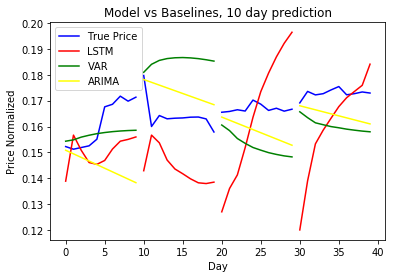

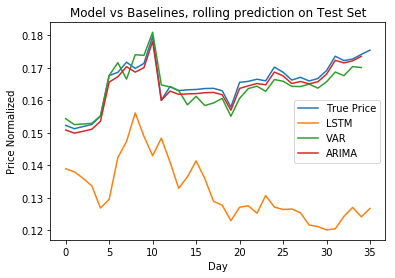

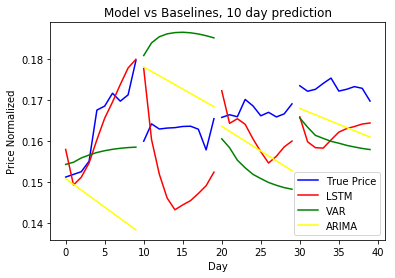

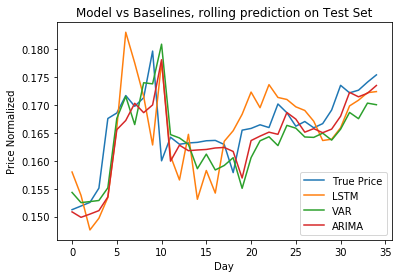

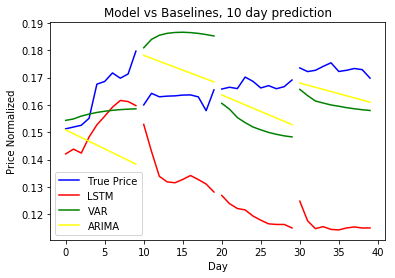

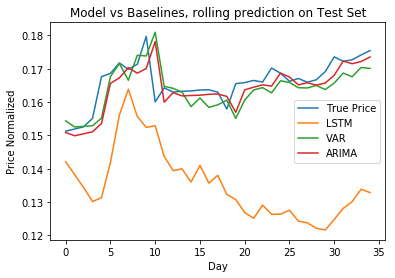

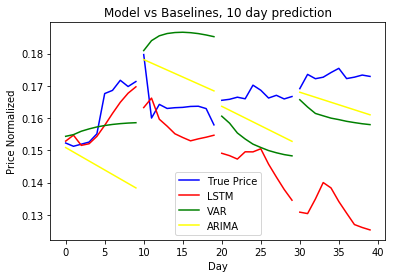

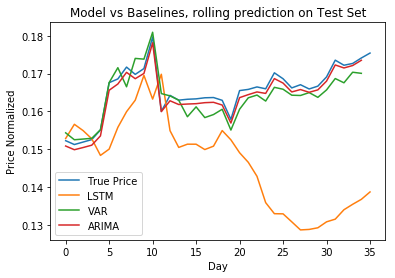

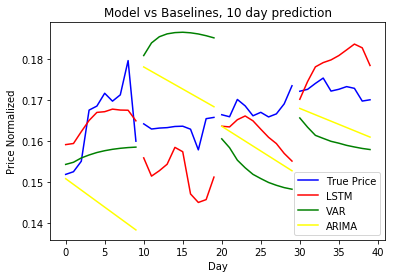

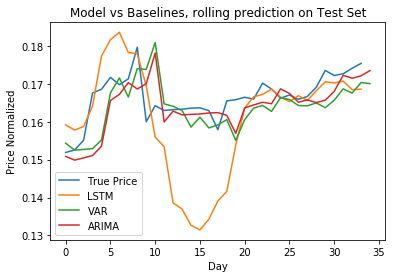

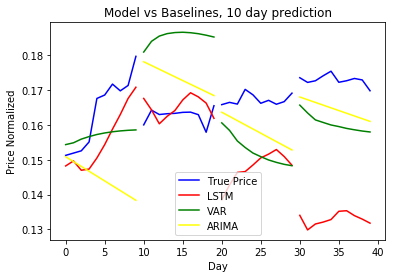

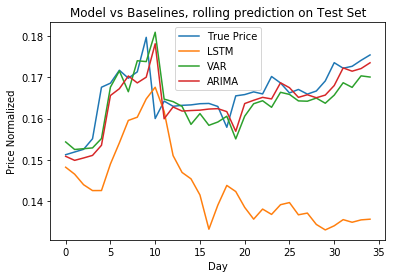

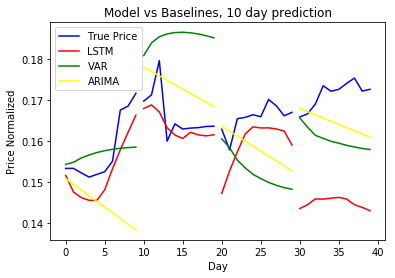

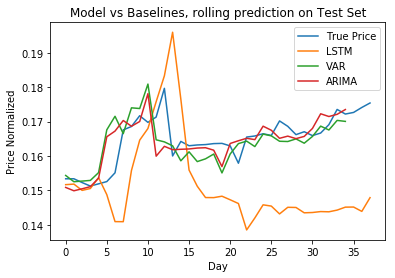

In [4]:

for i in range(14,21):
    save_dir = f'results/{i}/'
    if not os.path.exists(save_dir): os.makedirs(save_dir)
    hyperparams = utils.generate_hyperparams(1)
    hps = pd.DataFrame(hyperparams)
    hps.to_csv(save_dir+'hyperparams.csv')
    print(hps)
    results = []
    hyperparams_set = hyperparams[0]

    lr = hyperparams_set['lr']
    decay = hyperparams_set['decay']
    dropout_rate = hyperparams_set['dropout']
    num_units = hyperparams_set['num_units']
    num_input = hyperparams_set['wlen']
    batch_size = hyperparams_set['batch_size']
    num_out = 10
    epochs = 1000

    train_X, train_y, dev_X, dev_y, test_X, test_y, train_y_acc, dev_y_acc, test_y_acc = utils.prepare_data(data, num_input, num_preds=num_out)

    train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
    dev_y = dev_y.reshape((dev_y.shape[0], dev_y.shape[1], 1))
    test_y = test_y.reshape((test_y.shape[0], test_y.shape[1], 1))
    train_y_acc = train_y_acc.reshape((train_y.shape[0], train_y.shape[1], 1))
    dev_y_acc = dev_y_acc.reshape((dev_y.shape[0], dev_y.shape[1], 1))
    test_y_acc = test_y_acc.reshape((test_y.shape[0], test_y.shape[1], 1))

    input_shape = train_X.shape[1:]

    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=10, activation='relu', input_shape=input_shape))
    model.add(CuDNNLSTM(num_units))
    model.add(Dropout(dropout_rate))
    model.add(RepeatVector(num_out))
    model.add(CuDNNLSTM(num_units, return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(TimeDistributed(Dense(num_units, activation='relu')))
    model.add(TimeDistributed(Dense(1)))

    opt = Adam(lr=lr, decay=decay)
    model.compile(loss="mse", optimizer=opt)

    history = model_funcs.train(
        model,
        train_X,
        train_y,
        (dev_X, dev_y),
        epochs = epochs,
        batch_size = batch_size,
        save_dir = save_dir
    )

    preds_train = model.predict(train_X).squeeze()
    preds_dev = model.predict(dev_X).squeeze()
    preds_test = model.predict(test_X).squeeze()

    MSE_Train = mean_squared_error(preds_train.reshape(-1,1), train_y.reshape(-1,1))
    MSE_Dev = mean_squared_error(preds_dev.reshape(-1,1), dev_y.reshape(-1,1))
    MSE_Test = mean_squared_error(preds_test.reshape(-1,1), test_y.reshape(-1,1))

    MAE_Train = mean_absolute_error(preds_train.reshape(-1,1), train_y.reshape(-1,1))
    MAE_Dev = mean_absolute_error(preds_dev.reshape(-1,1), dev_y.reshape(-1,1))
    MAE_Test = mean_absolute_error(preds_test.reshape(-1,1), test_y.reshape(-1,1))

    result = [MSE_Train, MSE_Dev, MSE_Test, MAE_Train, MAE_Dev, MAE_Test]
    print(result)
    results.append(result)

    predicted_test = preds_test[::num_out]
    true_test = test_y[::num_out].squeeze()
    utils.plot_results_multiple_hp_search(predicted_test.tolist(), true_test.tolist(), \
                                          var_preds_test[::num_out].tolist(), arima_preds_test[::num_out].tolist(), \
                                          num_out, save_dir+'Test')

    utils.plot_rolling(test_y[:, 0], preds_test[:, 0], var_preds_test[:, 0], arima_preds_test[:, 0], save_dir) 

    results = pd.DataFrame(results, columns=['Train MSE', 'Dev MSE', 'Test MSE', 'Train MAE', 'Dev MAE', 'Test MAE'])
    results.to_csv(save_dir+'results.csv')

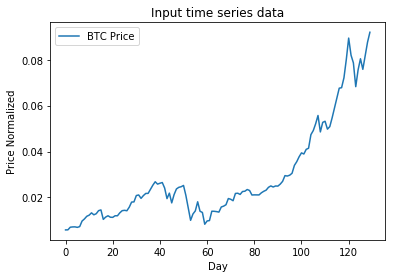

In [21]:
plt.plot(train_X[1,:,0], label='BTC Price')
plt.ylabel('Price Normalized')
plt.xlabel('Day')
plt.title('Input time series data')
plt.legend()

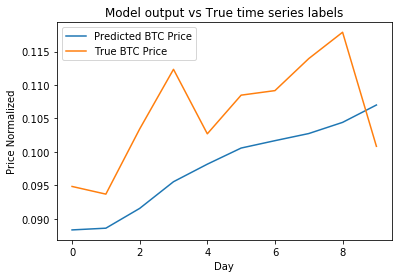

In [20]:
plt.plot(preds_train[1,:], label='Predicted BTC Price')
plt.plot(train_y[1,:], label='True BTC Price')
plt.ylabel('Price Normalized')
plt.xlabel('Day')
plt.title('Model output vs True time series labels')
plt.legend()